# Kaggle Home Credit Default Risk - First Neural Network

[Medium Source](https://medium.com/@williamkoehrsen/deep-neural-network-classifier-32c12ff46b6c)


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from datetime import datetime


# He et al. initialization from https://arxiv.org/abs/1502.01852
he_init = tf.contrib.layers.variance_scaling_initializer()

# This class inherits from Sklearn's BaseEstimator and ClassifierMixin 
class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=4, n_neurons=50, optimizer_class=tf.train.AdamOptimizer, learning_rate=0.005, 
                 batch_size=20, activation=tf.nn.elu, initializer=he_init, batch_norm_momentum=None, dropout_rate=None, 
                 max_checks_without_progress=20,show_progress=10, tensorboard_logdir=None, random_state=None):

        # Initialize the class with sensible default hyperparameters
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.max_checks_without_progress = max_checks_without_progress
        self.show_progress = show_progress
        self.random_state = random_state
        self.tensorboard_logdir = tensorboard_logdir
        self._session = None #Instance variables preceded by _ are private members

    def _dnn(self, inputs):
        '''This method builds the hidden layers and Provides for implementation of batch normalization and dropout'''

        for layer in range(self.n_hidden_layers):

            # Apply dropout if specified
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, rate=self.dropout_rate, training=self._training)
            
            # Create the hidden layer
            inputs = tf.layers.dense(inputs, self.n_neurons, activation=self.activation, kernel_initializer=self.initializer, 
                                     name = "hidden{}".format(layer+1))

            # Apply batch normalization if specified
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs,momentum=self.batch_norm_momentum, training=self._training)

            # Apply activation function
            inputs = self.activation(inputs, name="hidden{}_out".format(layer+1))
            
        return inputs

    def _construct_graph(self, n_inputs, n_outputs):
        '''This method builds the complete Tensorflow computation graph
            n_inputs: number of features 
            n_outputs: number of classes
        '''

        if self.random_state:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
 
        # Placeholders for training data, labels are class exclusive integers
        X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
        y = tf.placeholder(tf.int32, shape=[None], name="y")

        # Create a training placeholder 
        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=[], name="training")
        else:
            self._training = None

        # Output after hidden layers 
        pre_output = self._dnn(X)

        # Outputs from output layer
        logits = tf.layers.dense(pre_output, n_outputs, kernel_initializer=he_init, name="logits")
        probabilities = tf.nn.softmax(logits, name="probabilities")

        ''' Cost function is cross entropy and loss is average cross entropy. Sparse softmax must be used because shape of logits is [None, n_classes] and shape of labels is [None]'''
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        '''Optimizer and training operation. The control dependency is necessary for implementing batch normalization. The training operation must be dependent on the batch normalization.'''

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            training_op = optimizer.minimize(loss)

        # Metrics for evaluation
        correct = tf.nn.in_top_k(logits, y, 1)    
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        # Initializer and saver 
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        if self.tensorboard_logdir:
            now = datetime.utcnow().strftime('%Y%m%d-%H%M%S')
            tb_logdir = self.tensorboard_logdir + "/run-{}".format(now)
            cost_summary = tf.summary.scalar("validation_loss", loss)
            acc_summary = tf.summary.scalar("validation_accuracy", accuracy)
            merged_summary = tf.summary.merge_all()
            file_writer = tf.summary.FileWriter(tb_logdir, tf.get_default_graph())

            self._merged_summary = merged_summary
            self._file_writer = file_writer

        self._X, self._y = X, y
        self._logits = logits
        self._probabilities = probabilities
        self._loss = loss
        self._training_op = training_op
        self._accuracy = accuracy
        self._init, self._saver = init, saver


    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_parameters(self):
        # Retrieves the value of all the variables in the network 
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in 
                zip(gvars, self._session.run(gvars))}

    def _restore_model_parameters(self, model_params):
        # Restores the value of all variables using tf assign operations
        # First retrieve the list of all the graph variables
        gvar_names = list(model_params.keys())

        # Then retrieve all the assignment operations in the graph
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign") for gvar_name in gvar_names}

        # Fetch the initialization values of the assignment operations
        '''graph.get_operation_by_name(operation).inputs returns the input to the given operation; 
            because these are all assignment operations, the second argument to inputs is the value 
            assigned to the variable
        '''
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        
        # Create a dictionary mapping initial values to values after training
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        
        # Assign the trained value to all the variables in the graph
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        # Method to train the model. Implements early stopping if validation data is provided 

        self.close_session()
        n_inputs = X.shape[1] # Number of features

        # If labels are provided in one_hot form, convert to integer class labels
        y = np.array(y)
        y_valid = np.array(y_valid)

        if len(y.shape) == 2:
            y = np.argmax(y, axis=1)

        if len(y_valid.shape) == 2:
            y_valid = np.argmax(y_valid, axis=1)

        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_) # Number of classes

        # Tensorflow expects labels from 0 to n_classes - 1. 
        self.class_to_index_ = {label: index for index, label in enumerate(self.classes_)}
        labels = [self.class_to_index_[label] for label in y]
        y = np.array(labels, dtype=np.int32)

        self._graph = tf.Graph()

        # Build the computation graph with self as default graph
        with self._graph.as_default():
            self._construct_graph(n_inputs, n_outputs)

        # Early stopping parameters
        checks_without_progress = 0 
        best_loss = np.float("inf")
        best_parameters = None

        self._session = tf.Session(graph=self._graph)

        with self._session.as_default() as sess:
            # Initialize all variables
            self._init.run()
            num_instances = X.shape[0] # Total number of training instances
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(num_instances)
                for rnd_indices in np.array_split(rnd_idx, num_instances // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    train_acc, _ = sess.run([self._accuracy,self._training_op], feed_dict)

                # Early stopping implementation
                if X_valid is not None and y_valid is not None:
                    feed_dict_valid = {self._X: X_valid, self._y: y_valid}

                    # Write summary for tensorboard
                    if self.tensorboard_logdir:
                        val_acc, val_loss, summary = sess.run([self._accuracy, self._loss, self._merged_summary], feed_dict=feed_dict_valid)

                        self._file_writer.add_summary(summary, epoch)

                    else:
                        val_acc, val_loss = sess.run([self._accuracy, self._loss], feed_dict=feed_dict_valid)

                    # Show training progress every show_progress epochs
                    if self.show_progress:
                        if epoch % self.show_progress == 0:
                            print("Epoch: {} Current training accuracy: {:.4f} Validation Accuracy: {:.4f} Validation Loss {:.6f}".format(
                                epoch+1, train_acc, val_acc, val_loss))

                    # Check to see if model is improving 
                    if val_loss < best_loss:
                        best_loss = val_loss
                        checks_without_progress = 0
                        best_parameters = self._get_model_parameters()
                    else:
                        checks_without_progress += 1

                    if checks_without_progress > self.max_checks_without_progress:
                        print("Stopping Early! Loss has not improved in {} epochs".format(self.max_checks_without_progress))
                        break

                # No validation set provided
                else:
                    if self.show_progress:
                        if epoch % self.show_progress == 0:
                            print("Epoch: {} Current training accuracy: {:.4f}".format(epoch+1, train_acc))

            # In the case of early stopping, restore the best weight values
            if best_parameters:
                self._restore_model_parameters(best_parameters)
                return self

    def predict_probabilities(self, X):
        # Predict the probabilities of each class 
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._probabilities.eval(feed_dict={self._X: X})

    def predict(self, X):
        # Predict the classes themselves and return with shape=(None,)
        class_indices = np.argmax(self.predict_probabilities(X), axis=1)
        predictions = np.array([[self.classes_[class_index]] for class_index in class_indices], dtype=np.int32)
        return np.reshape(predictions, (-1,))

    def save(self, path):
        # Save the model to provided path
        self._saver.save(self._session, path)

In [ ]:
import numpy as np
import pandas as pd
import gc
import datetime as dt
import time
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

from utils import memory_reduce
from hcdr_prepross import hcdr_add_custom_features, hcdr_add_polynomial_features, hcdr_anomalous_corrections, hcdr_features_encoding
from hcdr_model import model
from hcdr_display import plot_features_importance, display_correlation
from hcdr_predictor import data_loader

In [ ]:
print('\n> Launch Preprocessing')
start = time.time()

app_train, app_test, template_submission = data_loader()

app_train, app_test = hcdr_anomalous_corrections(app_train, app_test)

app_train, app_test = hcdr_add_custom_features(app_train, app_test)

print('\t- Training data shape: ', app_train.shape)
print('\t- Testing data shape:  ', app_test.shape)

columns_for_poly = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
app_train, app_test = hcdr_add_polynomial_features(app_train, app_test, columns=columns_for_poly, label_column='TARGET', keyjoin='SK_ID_CURR')

app_train, app_test, cat_features = hcdr_features_encoding(app_train, app_test)

app_train = memory_reduce(app_train)
app_test = memory_reduce(app_test)

app_train_corrs = display_correlation(app_train, label='TARGET')

print('\n> Check Data Size')
print('\t- Training data shape: ', app_train.shape)
print('\t- Testing data shape:  ', app_test.shape)

print('\n> End Preprocessing in {}'.format(time.time() - start))

In [ ]:
train_labels = app_train['TARGET']

# Remove the ids and target
app_train = app_train.drop(columns = ['SK_ID_CURR', 'TARGET'])
app_test = app_test.drop(columns = ['SK_ID_CURR'])

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

In [ ]:
# from Features Importance RandomForestClassifier
selected_features = ['EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'ANNUITY_INCOME_PERCENT',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'SK_ID_CURR',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'CREDIT_TERM',
 'DAYS_EMPLOYED_PERCENT',
 'CREDIT_INCOME_PERCENT',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_2^2',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'AMT_CREDIT',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'EXT_SOURCE_2_y',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2_x',
 'EXT_SOURCE_2',
 'REGION_POPULATION_RELATIVE',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'DAYS_BIRTH_x',
 'DAYS_BIRTH_y',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'DAYS_BIRTH^3',
 'AMT_INCOME_TOTAL',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_3_y',
 'EXT_SOURCE_3',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3_x',
 'OWN_CAR_AGE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_1_x',
 'EXT_SOURCE_1_y',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1',
 'TOTALAREA_MODE',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'CNT_FAM_MEMBERS',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'LANDAREA_AVG',
 'APARTMENTS_MODE',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MODE',
 'BASEMENTAREA_MEDI',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MODE',
 'NONLIVINGAREA_MEDI',
 'COMMONAREA_AVG',
 'YEARS_BUILD_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MODE',
 'CNT_CHILDREN',
 'ENTRANCES_AVG',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'REGION_RATING_CLIENT',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'REGION_RATING_CLIENT_W_CITY',
 'FLOORSMAX_AVG',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'FLOORSMAX_MEDI',
 'CODE_GENDER_F',
 'FLOORSMAX_MODE',
 'FLOORSMIN_AVG',
 'CODE_GENDER_M']

In [ ]:
selected_features = app_train.columns

###### Training Control DNN

In [ ]:
# Test du DNN
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(app_train, train_labels, test_size=0.33, random_state=42)
X_test = app_test

In [ ]:
dnn = DNNClassifier(tensorboard_logdir="/tensorboard_stats", random_state=42)

In [ ]:
dnn.fit(X_train, y_train, 100, X_valid, y_valid)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = dnn.predict(X_valid)
print("Accuracy on the test set: {:.2f}%".format(accuracy_score(y_valid, y_pred) * 100))

In [36]:
print('Making predictions and praying for good results...')
y_pred = dnn.predict_probabilities(X_test)

# app_test['TARGET'] = y_pred
# app_test['TARGET'] = app_test['TARGET'].apply(lambda x: abs(x))

# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': [y[1] for y in y_pred]})

print('Saving predictions...')
# results = app_test[df_ssub.columns]
assert submission.shape == df_ssub.shape
submission.to_csv('../submissions/dnn_classifier_{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False, float_format='%.4f')
print('Done!')

Making predictions and praying for good results...
Saving predictions...
Done!


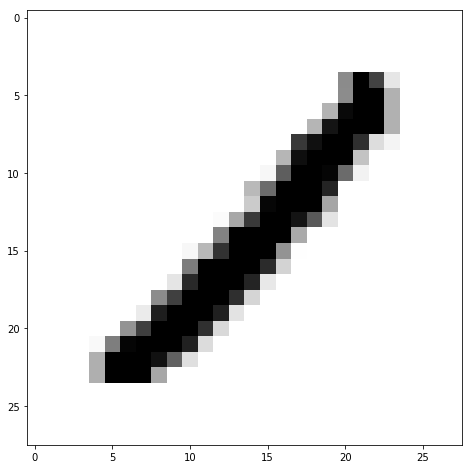

0 Confidence: 0.00%
1 Confidence: 100.00%
2 Confidence: 0.00%
3 Confidence: 0.00%
4 Confidence: 0.00%
5 Confidence: 0.00%
6 Confidence: 0.00%
7 Confidence: 0.00%
8 Confidence: 0.00%
9 Confidence: 0.00%


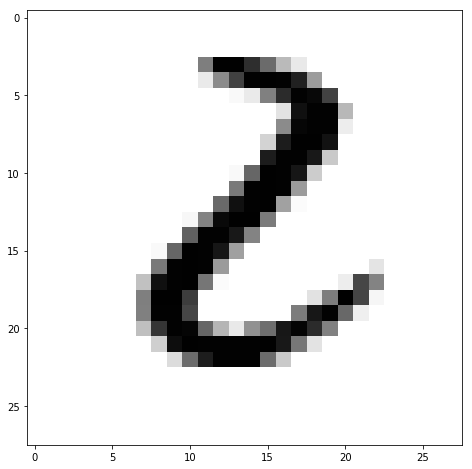

0 Confidence: 0.31%
1 Confidence: 10.90%
2 Confidence: 59.42%
3 Confidence: 14.99%
4 Confidence: 1.38%
5 Confidence: 2.50%
6 Confidence: 2.31%
7 Confidence: 1.47%
8 Confidence: 6.71%
9 Confidence: 0.01%


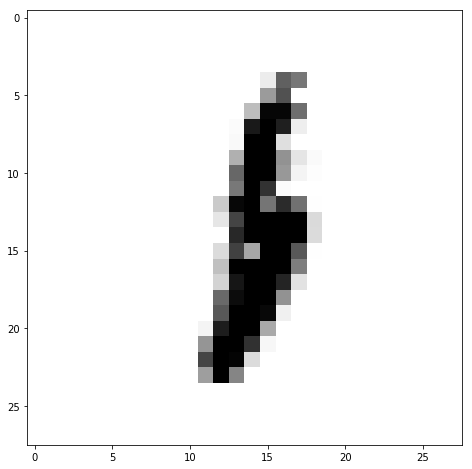

0 Confidence: 0.00%
1 Confidence: 100.00%
2 Confidence: 0.00%
3 Confidence: 0.00%
4 Confidence: 0.00%
5 Confidence: 0.00%
6 Confidence: 0.00%
7 Confidence: 0.00%
8 Confidence: 0.00%
9 Confidence: 0.00%


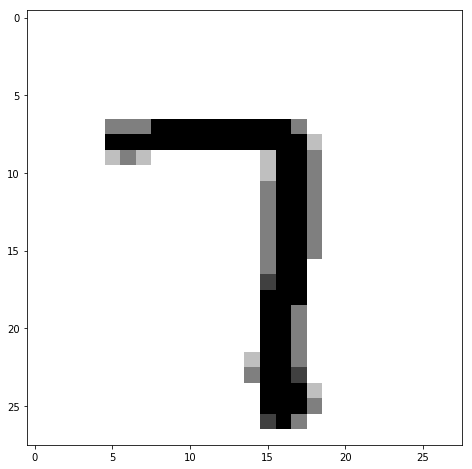

0 Confidence: 0.00%
1 Confidence: 0.00%
2 Confidence: 0.00%
3 Confidence: 0.00%
4 Confidence: 0.00%
5 Confidence: 0.00%
6 Confidence: 0.00%
7 Confidence: 100.00%
8 Confidence: 0.00%
9 Confidence: 0.00%


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# For plotting within the Jupyter Notebook
%matplotlib inline

# Pick random examples to predict
example_indices = np.random.randint(len(X_test), size=4)

# Plot the image itself and the predicted class probabilities
for i, image_index in enumerate(example_indices):
    probabilities = dnn.predict_probabilities(X_test[image_index].reshape(-1, 784))
    plt.figure(figsize=(8,8))
    plt.imshow(X_test[image_index].reshape(28,28), cmap="binary")
    plt.show()
    for label, probability in zip(dnn.classes_, probabilities[0]):
        print("{} Confidence: {:.2f}%".format(label, probability*100))

In [13]:
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf


# We do not need to print out progress for every classifier
dnn = DNNClassifier(show_progress=None, random_state=42)

# Hyperparameters of the neural network to test
parameter_distributions = {
    'n_hidden_layers': [3, 4, 5],
    'n_neurons': [40, 50, 100],
    'batch_size': [64, 128],
    'learning_rate':[0.01, 0.005],
    'activation': [tf.nn.elu, tf.nn.relu],
    'max_checks_without_progress': [20, 30],
    'batch_norm_momentum': [None, 0.9],
    'dropout_rate': [None, 0.5]
}

# Adjust iterations to a number sensible for your set-up
random_search = RandomizedSearchCV(dnn, parameter_distributions, n_iter=50, scoring='accuracy', verbose=2)

# Train the model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=100, n_hidden_layers=5, max_checks_without_progress=30, learning_rate=0.005, dropout_rate=None, batch_size=64, batch_norm_momentum=None, activation=<function relu at 0x000001B2230581E0> 
[CV]  n_neurons=100, n_hidden_layers=5, max_checks_without_progress=30, learning_rate=0.005, dropout_rate=None, batch_size=64, batch_norm_momentum=None, activation=<function relu at 0x000001B2230581E0>, total= 3.4min
[CV] n_neurons=100, n_hidden_layers=5, max_checks_without_progress=30, learning_rate=0.005, dropout_rate=None, batch_size=64, batch_norm_momentum=None, activation=<function relu at 0x000001B2230581E0> 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s


[CV]  n_neurons=100, n_hidden_layers=5, max_checks_without_progress=30, learning_rate=0.005, dropout_rate=None, batch_size=64, batch_norm_momentum=None, activation=<function relu at 0x000001B2230581E0>, total= 3.7min
[CV] n_neurons=100, n_hidden_layers=5, max_checks_without_progress=30, learning_rate=0.005, dropout_rate=None, batch_size=64, batch_norm_momentum=None, activation=<function relu at 0x000001B2230581E0> 
[CV]  n_neurons=100, n_hidden_layers=5, max_checks_without_progress=30, learning_rate=0.005, dropout_rate=None, batch_size=64, batch_norm_momentum=None, activation=<function relu at 0x000001B2230581E0>, total= 4.0min
[CV] n_neurons=50, n_hidden_layers=4, max_checks_without_progress=30, learning_rate=0.01, dropout_rate=None, batch_size=128, batch_norm_momentum=0.9, activation=<function elu at 0x000001B22304FE18> 
[CV]  n_neurons=50, n_hidden_layers=4, max_checks_without_progress=30, learning_rate=0.01, dropout_rate=None, batch_size=128, batch_norm_momentum=0.9, activation=<fu

KeyboardInterrupt: 

In [ ]:
random_search.best_params_

In [ ]:
best_mnist_dnn = random_search.best_estimator_
mnist_predictions = best_mnist_dnn.predict(X_test)
print("Accuracy on test set: {:.2f}%".format(accuracy_score(y_test, mnist_predictions) * 100))

In [ ]:
dnn = DNNClassifier(show_progress=None, random_state=42)
parameter_grid = {
    'n_hidden_layers': [3],
    'n_neurons': [75, 100, 125, 150],
    'batch_size': [64],
    'learning_rate':[0.005],
    'activation': [tf.nn.elu],
    'max_checks_without_progress': [20, 25],
    'batch_norm_momentum': [0.9, 0.95],
}
grid_search = GridSearchCV(dnn, parameter_grid, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)
predictions = grid_search.best_estimator_.predict(X_test)
accuracy_score(predictions, y_test)

In [ ]:
grid_search.best_estimator_.save("models/mnist_grid_best")